## Presidential Candidate Media Analysis
- This analysis investigated trends in volume of media coverage of the top 2020 Democratic presidential candidates from December 2018 to September 2019
- Questions to answer:
    - Who have been the most/least covered candidates?
    - Have there been any significant trends in coverage in the last four weeks? Three months? Six months?
    - Were there significant differences in coverage between candidates on cable and the internet?

- Hypotheses:
    - Joe Biden has been the most covered candidate but other candidates have seen increases in coverage in recent weeks.
    - There were no differences in coverage of candidates between news mediums. 
    
- Data source: https://github.com/fivethirtyeight/data/tree/master/media-mentions-2020

### Section I: Import data / packages

In [1]:
#Import packages
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
#Define function to import data from a csv file
def import_data(filepath):
    '''This function imports data from a csv file to a pandas dataframe'''
    return pd.read_csv(filepath)

In [3]:
#Import data
# directory = r'C:\Users\T2ZKQ0\Documents\Python Scripts\Media Analysis'
# cable_path = directory + '\\' + 'cable_weekly.csv'
# internet_path = directory + '\\' + 'online_weekly.csv'
# df_cable = import_data(cable_path)
# df_internet = import_data(internet_path)

In [4]:
#Import data
df_cable = import_data('cable_weekly.csv')
df_internet = import_data('online_weekly.csv')

### Section II: Data Exploration

#### Generate brief views of the datasets

In [5]:
df_cable.head()

,date,name,matched_clips,all_candidate_clips,total_clips,pct_of_all_candidate_clips,query
0,2018-12-30,Amy Klobuchar,12,1249,76029,0.009608,"(""Amy Klobuchar"") (station:MSNBC OR station:CN..."
1,2019-01-06,Amy Klobuchar,7,1013,82964,0.006910,"(""Amy Klobuchar"") (station:MSNBC OR station:CN..."
2,2019-01-13,Amy Klobuchar,45,596,82521,0.075503,"(""Amy Klobuchar"") (station:MSNBC OR station:CN..."
3,2019-01-20,Amy Klobuchar,10,962,83649,0.010395,"(""Amy Klobuchar"") (station:MSNBC OR station:CN..."
4,2019-01-27,Amy Klobuchar,16,1889,80994,0.008470,"(""Amy Klobuchar"") (station:MSNBC OR station:CN..."


In [6]:
df_internet.head()

,date,name,matched_stories,all_candidate_stories,pct_of_all_candidate_stories,query
0,2018-12-30,Amy Klobuchar,45.0,787,0.057179,"(""Amy Klobuchar"")"
1,2019-01-06,Amy Klobuchar,55.0,912,0.060307,"(""Amy Klobuchar"")"
2,2019-01-13,Amy Klobuchar,128.0,1028,0.124514,"(""Amy Klobuchar"")"
3,2019-01-20,Amy Klobuchar,54.0,1012,0.053360,"(""Amy Klobuchar"")"
4,2019-01-27,Amy Klobuchar,74.0,1594,0.046424,"(""Amy Klobuchar"")"


#### Show the summary statistics

In [7]:
def summary_stats(df):
    '''This function will print summary stats on the provided dataframe'''
    print(df.info(), '\n')
    print(df.describe())

In [8]:
#Show the summary stats of the cable dataset
summary_stats(df_cable)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 7 columns):
date                          899 non-null object
name                          899 non-null object
matched_clips                 899 non-null int64
all_candidate_clips           899 non-null int64
total_clips                   899 non-null int64
pct_of_all_candidate_clips    899 non-null float64
query                         899 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 49.3+ KB
None 

       matched_clips  all_candidate_clips   total_clips  \
count     899.000000           899.000000    899.000000   
mean      150.094549          2985.879867  90903.143493   
std       345.861583          1555.857778   6255.795004   
min         0.000000           596.000000  76029.000000   
25%         5.000000          1889.000000  83306.500000   
50%        29.000000          2967.000000  94380.000000   
75%       126.500000          3685.000000  95313.000000   
max   

- All data types appeared to have been read in correctly
- All numeric features except 'total_clips' appeared to be right skewed

In [9]:
#Show the summary stats of the internet dataset
summary_stats(df_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 6 columns):
date                            899 non-null object
name                            899 non-null object
matched_stories                 899 non-null float64
all_candidate_stories           899 non-null int64
pct_of_all_candidate_stories    899 non-null float64
query                           899 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 42.3+ KB
None 

       matched_stories  all_candidate_stories  pct_of_all_candidate_stories
count       899.000000             899.000000                    899.000000
mean        175.845384            1642.144605                      0.103190
std         225.871792             532.266216                      0.118649
min           0.000000             787.000000                      0.000000
25%          34.000000            1399.000000                      0.021673
50%          80.000000            1572.000000            

- Data types appeared to be correct
- All numeric features showed a right skew similar to the cable dataset

### Section II: Clean up datasets

In [10]:
#Drop query and total_clips features
df_cable_2 = df_cable.drop(['total_clips', 'query'], axis=1)
df_internet_2 = df_internet.drop('query', axis=1)

In [11]:
def format_dates(df, feat='date'):
    '''This function formats a provided date feature within a dataframe to date dtype'''
    df[feat] = pd.to_datetime(df[feat])
    df[feat] = df[feat].dt.date
    return df

In [12]:
#Format date dtype for both datasets
df_cable_3 = format_dates(df_cable_2)
df_internet_3 = format_dates(df_internet_2)

### Section III: Find the most/least covered candidates

In [13]:
def pivot_data(df, vals, idx=['name'], func=np.sum):
    '''
    This function creates a pivot table to aggregate data in a provided dataframe
    
    Inputs:
        df (dataframe): Dataframe to aggregate
        vals (list): List of features to use as the values arg in the pivot_table method
        idx (list): List of features to use as the index arg in the pivot_table method
    
    Output (dataframe): Aggregated dataframe
    '''
    return df.pivot_table(values=vals, index=idx, aggfunc=func)

In [14]:
def show_agg_data(df, sort_feat='pct_of_coverage'):
    '''
    This function sorts the provided dataframe by the given feature
    and prints the observations of the highest/lowest values
    
    Inputs:
        df (dataframe): Dataframe to sort
        sort_feat (str): Feature in input dataframe to sort by
        
    Output: None
    '''
    df_sorted = df.sort_values(sort_feat, ascending=False)
    
    print(df_sorted.iloc[:5])
    print('\n')
    print(df_sorted.iloc[-5:])

In [15]:
#Create aggregated dataframes
df_cable_agg = pivot_data(df_cable_3, ['matched_clips', 'all_candidate_clips'])
df_internet_agg = pivot_data(df_internet_3, ['matched_stories', 'all_candidate_stories'])

In [16]:
#Create required features in both df's
df_cable_agg['pct_of_coverage'] = df_cable_agg['matched_clips'] / df_cable_agg['all_candidate_clips']
df_internet_agg['pct_of_coverage'] = df_internet_agg['matched_stories'] / df_internet_agg['all_candidate_stories']

In [17]:
#Show the top/bottom candidates for the cable dataset
show_agg_data(df_cable_agg)

                  all_candidate_clips  matched_clips  pct_of_coverage
name                                                                 
Joe Biden                      110766          44743         0.403942
Bernie Sanders                 110766          19187         0.173221
Elizabeth Warren               110766          17421         0.157278
Kamala Harris                  110766          14462         0.130564
Beto O'Rourke                  110766           7813         0.070536


                     all_candidate_clips  matched_clips  pct_of_coverage
name                                                                    
Marianne Williamson               110766            576         0.005200
Michael Bennet                    110766            487         0.004397
Seth Moulton                      101602            389         0.003829
Mike Gravel                        94826             17         0.000179
Joe Sestak                        110766              7         0.0000

- Joe Biden showed significantly more coverage on cable networks when compared to the remaining top five candidates
- All candidates in the bottom five showed very low coverage

In [18]:
#Show the top/bottom candidates for the internet dataset
show_agg_data(df_internet_agg)

                  all_candidate_stories  matched_stories  pct_of_coverage
name                                                                     
Bernie Sanders                    60630          22092.0         0.364374
Joe Biden                         60630          21055.0         0.347270
Elizabeth Warren                  60630          20833.0         0.343609
Kamala Harris                     60630          16502.0         0.272175
Cory Booker                       60630          10518.0         0.173478


               all_candidate_stories  matched_stories  pct_of_coverage
name                                                                  
Steve Bullock                  60630           1795.0         0.029606
Seth Moulton                   56510           1335.0         0.023624
Tom Steyer                     60630           1373.0         0.022646
Mike Gravel                    53553            348.0         0.006498
Joe Sestak                     60630            246.0 

- There was a smaller range in online coverage between the top five candidates when compared to top candidates for cable coverage
- The candidates in the top five were the same with the exception of Cory Booker replacing Beto O'Rourke in fifth
- The bottom candidates showed similarly negligible online coverage compared to cable

### Section IV: Look for trends in coverage of the top candidates

In [19]:
def subset_df(df, slice_feat, feat_vals):
    '''
    This function takes a dataframe input and returns a copy of a subset based on 
    provided feature and feature values.
    
    Inputs:
        df (dataframe): Dataframe to subset
        slice_feat (str): Name of feature to create a subset on
        feat_vals (list): List of feature observation values to subset the dataframe on
    
    Output (dataframe): Subsetted dataframe
    '''
    df_new = df.loc[df[slice_feat].isin(feat_vals), ].copy()
    df_new.reset_index(inplace=True, drop=True)
    return df_new

In [20]:
#Store list of candidates in the top 5 of coverage for both news mediums
top_candidates = ['Bernie Sanders', "Beto O'Rourke", 'Cory Booker', 
                  'Elizabeth Warren','Joe Biden', 'Kamala Harris']

In [21]:
#Create new df's based on names in top_candidates
df_cable_top = subset_df(df_cable_3, 'name', top_candidates)
df_internet_top = subset_df(df_internet_3, 'name', top_candidates)

In [22]:
def time_series(x, y, data, title, xlabel='Date', ylabel='Proportion of Candidate Coverage'):
    '''
    This function generates a line plot with the data provided.
    
    Inputs:
        x (str): Feature in data to plot on x-axis
        y (str): Feature in data to plot on y-axis
        data (dataframe): Pandas dataframe containing x and y to plot
        title (str): Title of chart
        xlabel (str): Label of x-axis
        ylabel (str): Label of y-axis
        
    Output: None
    '''
    ts_plot = sns.lineplot(x, y, hue='name', data=data)

    handles, labels = ts_plot.get_legend_handles_labels()
    ts_plot.legend(handles=handles[1:], labels=labels[1:], title='Candidate', bbox_to_anchor=(1, 1))

    ts_plot.set_title(title)
    ts_plot.set_xlabel(xlabel)
    ts_plot.tick_params(axis='x', rotation=45)
    ts_plot.set_ylabel(ylabel)
    plt.show()

/Users/jacoblangley/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


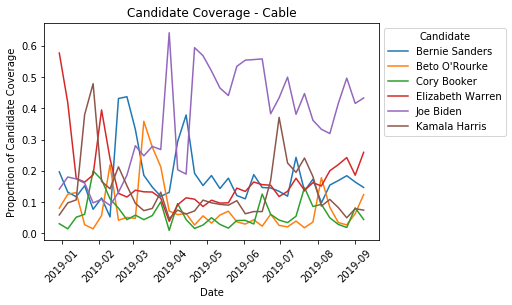

In [23]:
#Generate Cable covereage time series plot
time_series('date', 'pct_of_all_candidate_clips', df_cable_top, 'Candidate Coverage - Cable')

- Joe Biden consistently maintained a higher level of coverage than other candidates from mid-April through September
- The cable coverage on Elizabeth Warren trended steadily upward from May through September
- Coverage of Kamala Harris peaked in July but steadily dropped through September

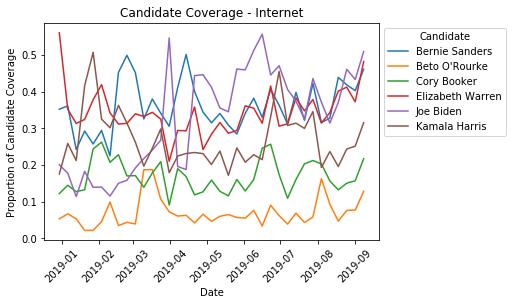

In [24]:
#Generate Internet covereage time series plot
time_series('date', 'pct_of_all_candidate_stories', df_internet_top, 'Candidate Coverage - Internet')

- There were no significant trends in online coverage for any candidates

### Section V: Look for statistically significant differences in coverage by news medium

#### Show median coverage for top candidates

In [25]:
#Create df containing the overall median cable coverage for each candidate
df_cable_top_agg = pivot_data(df_cable_top, 'pct_of_all_candidate_clips', func=np.median)

In [26]:
#Create df containing the overall median internet coverage for each candidate
df_internet_top_agg = pivot_data(df_internet_top, 'pct_of_all_candidate_stories', func=np.median)

In [27]:
#Combine, format, and display data
df_top_agg = df_cable_top_agg.merge(df_internet_top_agg, how='left', on='name')
df_top_agg_2 = df_top_agg.reset_index()
df_top_agg_2.columns = ['Candidate', 'Portion of Cable Coverage', 'Portion of Internet Coverage']
df_top_agg_3 = df_top_agg_2.set_index('Candidate')

In [28]:
#Show data
df_top_agg_3

,Portion of Cable Coverage,Portion of Internet Coverage
Candidate,,
Bernie Sanders,0.152807,0.344044
Beto O'Rourke,0.056306,0.060763
Cory Booker,0.050182,0.160468
Elizabeth Warren,0.145135,0.339443
Joe Biden,0.381314,0.355304
Kamala Harris,0.097730,0.245547


- From a high level, it appeared that all candidates except Beto O'Rourke and Joe Biden showed large differences in coverage between cable and the internet

#### Look at the data distribution to determine which statistical test is appropriate

In [29]:
def plot_dist(df, plot_feat, split_feat, split_vals, title, rows=2, cols=3):
    '''
    This function generates histograms of a specified feature, split into 
    subplots by a specified feature/values
    
    Inputs:
        df (dataframe): Dataframe containing data to plot
        plot_feat (str): Name of feature within df to plot
        split_feat (str): Name of feature to use to split data into subplots
        split_vals (list): List of values contained in split_feat
        title (str): Overall chart title
        rows(int): Number of rows of subplots
        cols (int): Number of columns of subplots
        
    Output: None
    '''
    fig, axs = plt.subplots(nrows=rows, ncols=cols, sharex=True)
    axs = axs.flat
    for ax, split_val in zip(axs, split_vals):
        ax.hist(df.loc[df_cable_top[split_feat]==split_val, plot_feat])
        ax.set_title(split_val)
    fig.tight_layout()
    fig.suptitle(title, y=1.1)
    plt.show()

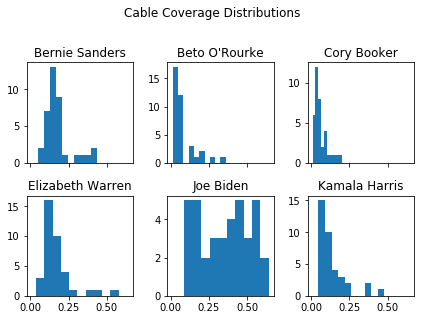

In [30]:
#Generate histograms of portions of total candidate coverege by candidate for cable news
plot_dist(df_cable_top, 'pct_of_all_candidate_clips', 'name', top_candidates, 'Cable Coverage Distributions')

- All candidates except Joe Biden showed a right skewed distribution in cable coverage
- None of the candidates showed coverage distributions that were obviously normal

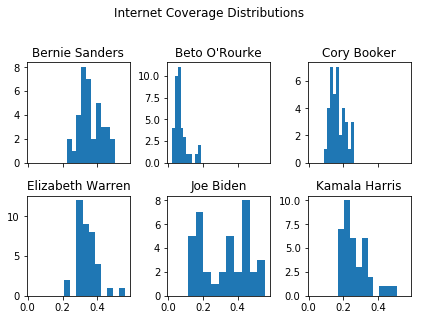

In [31]:
#Generate histograms of portions of total candidate coverege by candidate for online news
plot_dist(df_internet_top, 'pct_of_all_candidate_stories', 'name', top_candidates, 'Internet Coverage Distributions')

- Internet coverage of some candidates was approximately normal while others shows bi-modal or tri-modal behavior.
- A normality test will be needed to choose the appropriate statistical test

#### Perform normality test

In [32]:
#Populate a dict with Shapoiro-Wilks test results
dfs = [df_cable_top, df_internet_top]
feats = ['pct_of_all_candidate_clips', 'pct_of_all_candidate_stories']
medium = ['Cable', 'Internet']

sw_test_results = {}

for df, feat, med in zip(dfs, feats, medium):
    for candidate in top_candidates:
        test = scipy.stats.shapiro(df.loc[df['name']==candidate, feat])
        id_ = med + ', ' + candidate
        sw_test_results[id_] = test 

In [33]:
#Show medium/candidate pairs where the data is normally distributed
##(where the p-value is greater than the threshold)
threshold = 0.05
for i, j in sw_test_results.items():
    if j[1] > threshold:
        print(i)

Cable, Joe Biden
Internet, Bernie Sanders
Internet, Cory Booker


- A minority of the medium/candidate datasets were normally distributed
- A non-parametric statistical test was needed to evaluate the data

#### Compare coverage of each candidate between news mediums
- Null hypothesis: There was no difference in coverage of candidates between cable and online media

In [34]:
#Perform Mood's Median Test to determine if there was a statistically significant
##difference in the cable and online coverage of each candidate
med_test_results = []

for candidate in top_candidates:
    cable_data = df_cable_top.loc[df_cable_top['name']==candidate, 'pct_of_all_candidate_clips']
    internet_data = df_internet_top.loc[df_internet_top['name']==candidate, 'pct_of_all_candidate_stories']
    test = scipy.stats.median_test(cable_data, internet_data)
    med_test_results.append((candidate, test))

In [35]:
#Show candidates who have significantly different coverage
for i in med_test_results:
    if i[1][1] < threshold:
        print(i)

('Bernie Sanders', (36.54054054054054, 1.4952382971995519e-09, 0.2933038828179493, array([[ 5, 32],
       [32,  5]])))
('Cory Booker', (42.37837837837838, 7.521698652743146e-11, 0.1202503647230458, array([[ 4, 33],
       [33,  4]])))
('Elizabeth Warren', (48.648648648648646, 3.061792058783724e-12, 0.28524799268865686, array([[ 3, 34],
       [34,  3]])))
('Kamala Harris', (31.135135135135137, 2.4067536017440837e-08, 0.19914414004560926, array([[ 6, 31],
       [31,  6]])))


- The null hypothesis was rejected for four of the top six candidates
- The majority of the top candidates did show a statistically significant difference in media coverage between cable and the internet

### Summary
An analysis investigating the cable and internet media coverage of 2020 democratic presidential candidates was performed to answer several questions.
- The most and least covered candidates from December 2018 to September 2019 were determined
- Of the most covered candidates, time series trends were highlighted and discussed
- Statistically significant differences between cable and internet coverage of candidates was discussed
- Overall, the hypothesis that Joe Biden was the most covered candidate held for cable news but was not supported by the internet coverage data
- The hypothesis that there were no differences in coverage between cable and internet media was not supported by the data